In [97]:
# Libraries used for this Project
import os # used for interaction with the operating system 
import random # used for picking up random varaibales
import pandas as pd # used for structuring the data in dataframe
import numpy as np # used for preprocessing the data in an matrix or array format
import matplotlib.pyplot as plt # used for ploting the images and graphs
plt.style.use("ggplot") # used to plot in ggplot style
%matplotlib inline
from tqdm import tqdm_notebook, tnrange # used for printing the status bar
from itertools import chain # used for iteration 
from skimage.io import imread, imshow, concatenate_images # Scikit learn package for reading, showing and concatinating image size
from skimage.transform import resize # Scikit learn package for resizing the image dimensions
from skimage.morphology import label
from sklearn.model_selection import train_test_split # Scikit learn package used for test train split
import tensorflow as tf # used for training inference of deep learning architecture
from keras.models import Model, load_model # Keras package used for defining the model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout # Keras package used for construsting the input, Batch Norm
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose # Keras package used for defining the Convolution2D layers
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D # Keras package used for defining the MaxPool
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # Keras package used for defining the calback for early stop
from keras.optimizers import Adam # Keras package used for defining the model optimizer as ADAM
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical


In [98]:
# Initialising the compression dimensions
img_width = 256 # Defining the width of image
img_height =256 # Defining the Height of image
border = 5 # Defining the boder size


In [99]:
# Extracting the file names of the images and masks in training, test and validation folders
isic_train = next(os.walk("D:/ISIC2018_Task1-2_Training_Input_x2"))[2] # returns all the files "DIR."
isic_seg_train=next(os.walk("D:/ISIC2018_Task1_Training_GroundTruth_x2"))[2] # returns all the files "DIR."

print("No. of images in training folder= ",len(isic_train))
print("No. of images in test folder= ",len(isic_seg_train))


No. of images in training folder=  2594
No. of images in test folder=  2594


In [100]:
isic_train_sort=sorted(isic_train) # Sorting of data with respect to labels
isic_seg_train_sort=sorted(isic_seg_train) # Sorting of data with respect to labels


In [102]:
def Load_img(inp_path,isic):
    """ This function is used for Loading the images from the Training_Input_x2 folder"""
    " - Storing them with the above dimensions specified"
    " - Loading the images in Greayscale format"
    " - Normalizing the image with 255 as Normalising data by dividing it by 255 should improve activation functions performance"
    " - Sigmoid function works more efficiently with data range 0.0-1.0."
    
    X= np.zeros((len(isic),img_height,img_width,1),dtype=np.float32)
    for n, id_ in tqdm_notebook(enumerate(isic), total=len(isic)): # capture all the images ids using tqdm
        img = load_img(inp_path+id_, color_mode = 'grayscale')  # Load images here
        x_img = img_to_array(img) # Convert images to array
        x_img = resize(x_img,(256,256,1),mode = 'constant',preserve_range = True)
        X[n] = x_img/255 # Normalize the images
    return X
    

In [103]:
def Load_segmentation(inp_path,isic):
    """ This function is used for Loading the images from the Training_GroundTruth_x2 folder"""
    " - Storing them with the above dimensions specified"
    " - Loading the images in Greayscale format"
       
    X= np.zeros((len(isic),img_height,img_width,1),dtype=np.uint8)
    for n, id_ in tqdm_notebook(enumerate(isic), total=len(isic)):
        # Load images
        img = load_img(inp_path+id_,color_mode = 'grayscale')
        x_img = img_to_array(img)
        x_img = resize(x_img,(256,256,1),mode = 'constant', preserve_range = True)
        X[n] = x_img
    return X

In [104]:
# Loading the images for the training data set
X_ISIC_train = Load_img("D:/ISIC2018_Task1-2_Training_Input_x2/",isic_train_sort)

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


In [105]:
# Loading the image for segmentation(labes) dataset
Y_ISIC_train=Load_segmentation("D:/ISIC2018_Task1_Training_GroundTruth_x2/",isic_seg_train_sort)


C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [106]:
# Train and Test Split in 80:20 ratio 
X_train, X_test, y_train, y_test = train_test_split(X_ISIC_train, Y_ISIC_train, test_size=0.20, random_state=42)

In [107]:
# Train and Validation Split in 60:20 ratio
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [108]:
# - Normalizing the image with 255 as Normalising data by dividing it by 255 should improve activation functions performance
# - Sigmoid function works more efficiently with data range 0.0-1.0."
Y_ISIC_train_sc = y_train//255
Y_ISIC_test_sc = y_test//255
Y_ISIC_val_sc = y_val//255

In [109]:
Y_ISIC_train_cat = to_categorical(Y_ISIC_train_sc) # one hot encoding
Y_ISIC_test_cat = to_categorical(Y_ISIC_test_sc) # one hot encoding
Y_ISIC_val_cat = to_categorical(Y_ISIC_val_sc) # one hot encoding

In [110]:
# Dice Coeffient
from keras import backend as K
def dice_coeff(y_true, y_pred, smooth=1):
    """This Function is used to gauge similarity of two samples"""
    "When applied to Boolean data, using the definition of true positive (TP), false positive (FP), and false negative (FN)"
    
    intersect = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersect
    coeff_dice = K.mean((intersect + smooth) / (union + smooth), axis=0)
    return coeff_dice

In [111]:
def dice_loss(y_true, y_pred, smooth = 1):
    """This Function returns the dice loss by subtracting the dice_coeff similarity by 1 of the two samples"""
    
    return 1 - dice_coeff(y_true, y_pred, smooth = 1)

In [112]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """This Function is used to define the Conv2D layers by defining the filters, kernalsize and kernal initilizer"""
    
    # first layer
    layer = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    # It draws samples from a truncated normal distribution centered on 0 
    if batchnorm:
        layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    # second layer
    layer = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        layer = BatchNormalization()(layer)
    layer = Activation("relu")(layer)
    return layer


In [113]:
def generat_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    """This Function is used to define the Architecture of the U-Net model for the Contracting and Expanding path"""
    
    # contracting path - reduce enoder part
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path - Decoder part
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [114]:

input_img = Input((img_height, img_width, 1), name='img') # used for assigning the input image with the dimensions specified above
model = generat_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True) # calls the U-Net architecture for the specifid dataset
model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy",dice_coeff]) # compiling the model using the dice_loss

In [115]:
model.summary() # Extracting the model summary

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 256, 256, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_92 (BatchNo (None, 256, 256, 16) 64          conv2d_97[0][0]                  
__________________________________________________________________________________________________
activation_92 (Activation)      (None, 256, 256, 16) 0           batch_normalization_92[0][0]     
____________________________________________________________________________________________

In [116]:
# train the model. callbacks to save the model while training, 
# lower the learning rate if the validation loss plateaus and performing early stopping.

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-ISIC.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [117]:
results = model.fit(X_train, Y_ISIC_train_cat, batch_size=32, epochs=50, callbacks=callbacks,
                    validation_data=(X_val, Y_ISIC_val_cat))


Train on 1556 samples, validate on 519 samples
Epoch 1/50
1556/1556 [==============================] - 15s 9ms/step - loss: 0.4650 - accuracy: 0.7850 - dice_coeff: 0.5356 - val_loss: 0.6251 - val_accuracy: 0.5586 - val_dice_coeff: 0.3745

Epoch 00001: val_loss improved from inf to 0.62514, saving model to model-ISIC.h5
Epoch 2/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.3422 - accuracy: 0.8833 - dice_coeff: 0.6581 - val_loss: 0.3407 - val_accuracy: 0.8851 - val_dice_coeff: 0.6585

Epoch 00002: val_loss improved from 0.62514 to 0.34072, saving model to model-ISIC.h5
Epoch 3/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.2736 - accuracy: 0.9089 - dice_coeff: 0.7268 - val_loss: 0.2830 - val_accuracy: 0.8869 - val_dice_coeff: 0.7164

Epoch 00003: val_loss improved from 0.34072 to 0.28300, saving model to model-ISIC.h5
Epoch 4/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.2209 - accuracy: 0.9179 - dice_coeff: 0.7788

1556/1556 [==============================] - 13s 8ms/step - loss: 0.0872 - accuracy: 0.9514 - dice_coeff: 0.9128 - val_loss: 0.0982 - val_accuracy: 0.9431 - val_dice_coeff: 0.9015

Epoch 00032: val_loss did not improve from 0.09712
Epoch 33/50
1556/1556 [==============================] - 13s 9ms/step - loss: 0.0861 - accuracy: 0.9521 - dice_coeff: 0.9140 - val_loss: 0.0981 - val_accuracy: 0.9424 - val_dice_coeff: 0.9015

Epoch 00033: val_loss did not improve from 0.09712
Epoch 34/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.0859 - accuracy: 0.9520 - dice_coeff: 0.9140 - val_loss: 0.1002 - val_accuracy: 0.9413 - val_dice_coeff: 0.8997

Epoch 00034: val_loss did not improve from 0.09712
Epoch 35/50
1556/1556 [==============================] - 13s 8ms/step - loss: 0.0873 - accuracy: 0.9513 - dice_coeff: 0.9126 - val_loss: 0.0985 - val_accuracy: 0.9423 - val_dice_coeff: 0.9013

Epoch 00035: val_loss did not improve from 0.09712
Epoch 36/50
1556/1556 [=============

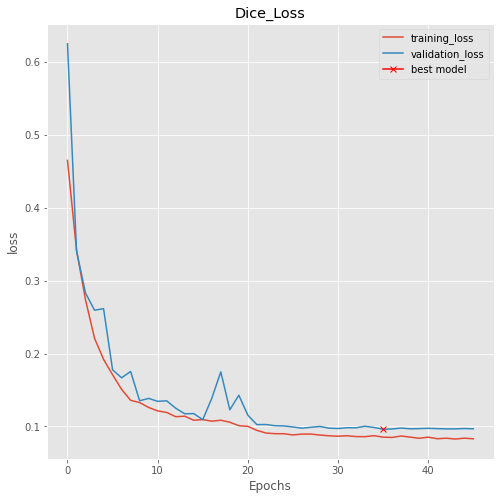

In [118]:
# used for plotting the graph of the training and Validation loss with respect to epoch
plt.figure(figsize=(8, 8))
plt.title("Dice_Loss")
plt.plot(results.history["loss"], label="training_loss")
plt.plot(results.history["val_loss"], label="validation_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();


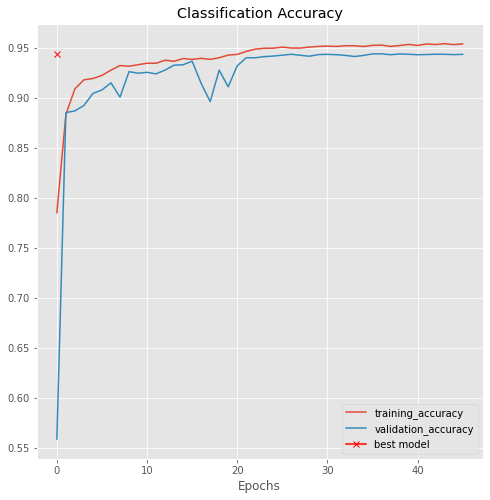

In [119]:
# Plotting the training and validation accuracy with respect to epochs
plt.figure(figsize=(8,8))
plt.title("Classification Accuracy")
plt.plot(results.history["accuracy"],label="training_accuracy")
plt.plot(results.history["val_accuracy"],label="validation_accuracy")
plt.plot(np.argmin(results.history["val_accuracy"]),np.max(results.history["val_accuracy"]),marker="x",color="r",label="best model")
plt.xlabel("Epochs")
plt.legend();

In [120]:
# load the best model
model.load_weights('model-ISIC.h5')
test_preds=model.predict(X_test,verbose=1) # predict the model
test_preds_max=np.argmax(test_preds,axis=-1) # Returns the indices of the maximum values along an axis

519/519 [==============================] - 1s 3ms/step


In [121]:
n,h,w,g=y_test.shape
test_preds_reshape=test_preds_max.reshape(n,h,w,g)

In [122]:
def plot_Oasis(X, y, Y_pred,ix=None):
    """This function is used for ploting the True image vs the Predictive image from the above model"""
    if ix is None:
        ix = random.randint(0, len(X))
    else:
        ix = ix
    

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    ax[0].contour(X[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input Image')
    
    
    ax[1].imshow(y[ix, ..., 0], cmap='gray')
    ax[1].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[1].set_title('True Image')
    
    ax[2].imshow(Y_pred[ix, ..., 0], cmap='gray')
    ax[2].contour(Y_pred[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Image')
    
    
   


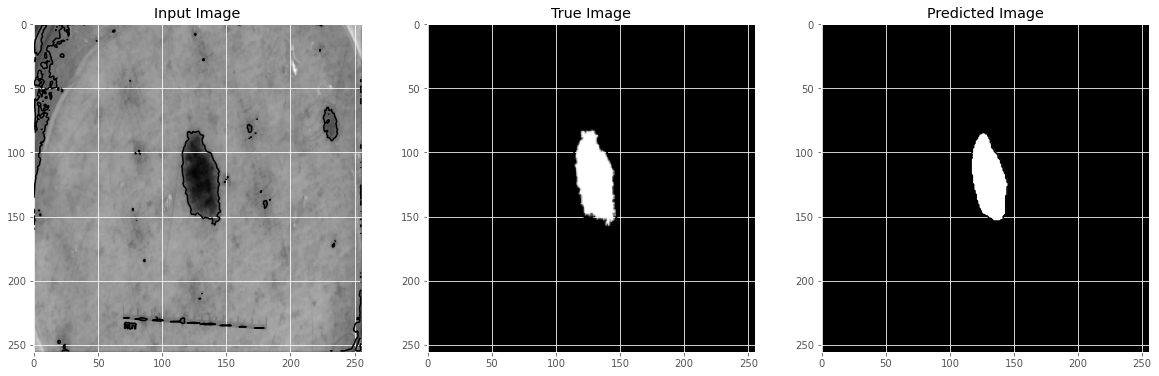

In [123]:
plot_Oasis(X_test,y_test,test_preds_reshape)

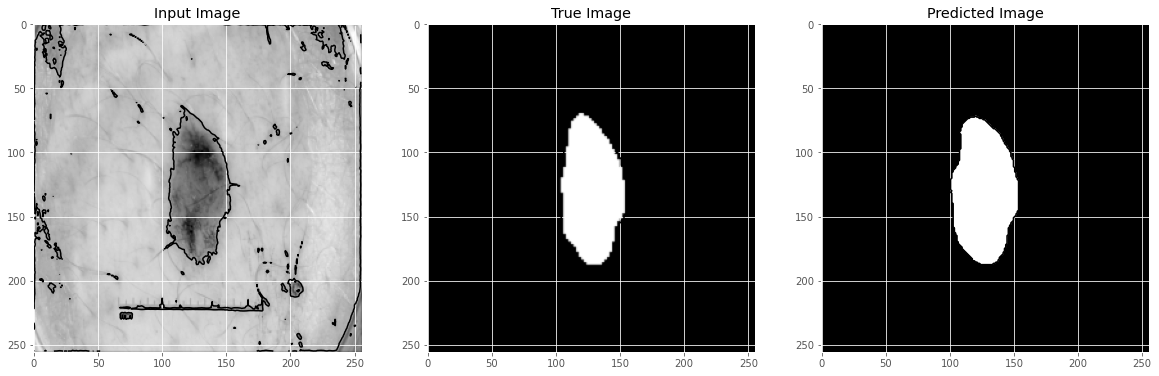

In [124]:
plot_Oasis(X_test,y_test,test_preds_reshape)

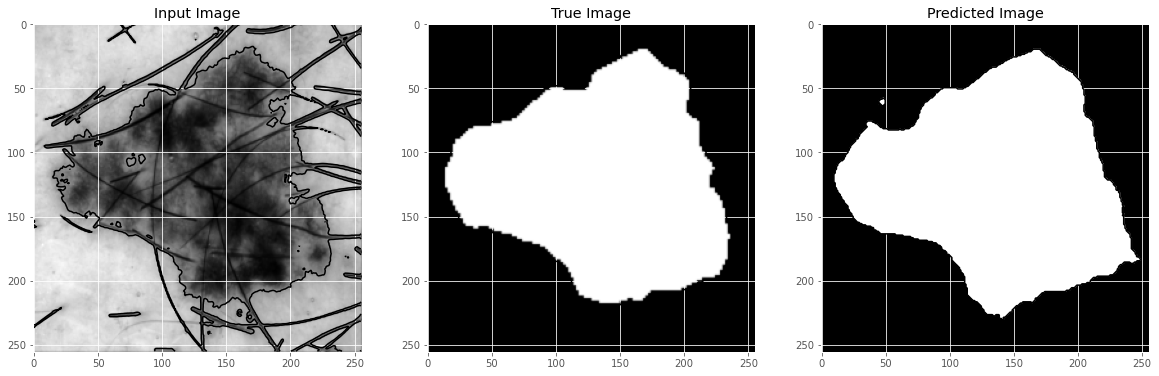

In [132]:
plot_Oasis(X_test,y_test,test_preds_reshape)